<a href="https://githubtocolab.com/geonextgis/geeagri/blob/main/docs/examples/image_scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

Uncomment the following line to install the latest version of [geeagri](https://geonextgis.github.io/geeagri) if needed.

In [1]:
# !pip install -U geeagri

## Import Libraries

In [3]:
import ee
import geemap
from geeagri.preprocessing import Sentinel2CloudMask, RegularTimeseries
from geeagri.phenology import SavitzkyGolayEE, Phenometrics
from geeagri.extract import extract_timeseries_to_point
import matplotlib.cm as cm
from matplotlib.colors import to_hex

## Initialize a Map object
Authenticate and initialize Earth Engine. If it doesn't work, specify a project name

In [4]:
# ee.Authenticate()
# ee.Initialize(project='your-project-id')

Map = geemap.Map(basemap="SATELLITE")
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

## Import region of interest

In [8]:
bbox = [-93.79303, 43.009668, -93.753891, 43.038031]
region = ee.Geometry.BBox(*bbox)
region_style = {"color": "red", "width": 1}
Map.addLayer(region, region_style, "Region")
Map.centerObject(region, 14)

## Import Cropland Data Layer (CDL)

In [9]:
croplandcover = (
    ee.ImageCollection("USDA/NASS/CDL")
    .filterDate("2020-01-01", "2021-01-01")
    .first()
    .clip(region)
)

cultivated = croplandcover.select("cultivated").eq(2).selfMask()
croplandcover = croplandcover.select("cropland")
Map.addLayer(cultivated, {"palette": "yellow"}, "Cultivated")
Map.addLayer(croplandcover, {}, "Crop Landcover")

## Load Sentinel-2 image collection and mask clouds and shadows

In [13]:
s2_cloud_masker = Sentinel2CloudMask(
    region=region,
    start_date="2020-01-01",
    end_date="2021-01-01",
    cloud_filter=60,
    cloud_prob_threshold=50,
    nir_dark_threshold=0.15,
    shadow_proj_dist=1,
    buffer=50,
)

s2_cloud_masked = s2_cloud_masker.get_cloudfree_collection()

## Calculate Green Chlorophyll Vegetation Index (GCVI)

In [14]:
def calculateGCVI(image):
    gcvi = image.expression(
        "(NIR/Green) - 1", {"NIR": image.select("B8"), "Green": image.select("B3")}
    ).copyProperties(image, ["system:time_start"])

    gcvi = ee.Image(gcvi).rename("gcvi").clip(region)

    return gcvi


gcvi_col = s2_cloud_masked.map(calculateGCVI)

## Smooth the timeseries and extract the phenometrics

In [15]:
# Instantiate an object of 'RegularTimeseries'
reg_timeseries = RegularTimeseries(gcvi_col, interval=5, window=45)

# Get the regular timeseries
gcvi_col_regular= reg_timeseries.get_regular_timeseries()

In [16]:
sg = SavitzkyGolayEE(
    image_collection=gcvi_col, window_length=11, polyorder=2, band_name="gcvi"
)

coeff = sg.coefficients()

phenometrics = Phenometrics(coeff)
metrics = phenometrics.metrics()

## Plot the land surface phenology

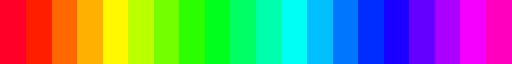

In [23]:
cmap = cm.get_cmap("gist_rainbow", 20)
cmap

In [17]:
cmap = cm.get_cmap("gist_rainbow", 20)
cmap = [to_hex(cmap(i)) for i in range(cmap.N)]

vis = {"min": 100, "max": 330, "palette": cmap}

Map.addLayer(metrics.select("SOS"), vis, "SOS")
Map.addLayer(metrics.select("POS"), vis, "POS")
Map.addLayer(metrics.select("EOS"), vis, "EOS")

## Apply on MODIS Data

In [12]:
modis = (
    ee.ImageCollection("MODIS/061/MOD13Q1")
    .filterDate("2020-01-01", "2021-01-01")
    .map(lambda img: img.clip(region))
)

sg = SavitzkyGolayEE(
    image_collection=modis, window_length=15, polyorder=2, band_name="NDVI"
)

coeff = sg.coefficients()

phenometrics = Phenometrics(coeff)
metrics = phenometrics.metrics()

cmap = cm.get_cmap("gist_rainbow", 20)
cmap = [to_hex(cmap(i)) for i in range(cmap.N)]

vis = {"min": 100, "max": 330, "palette": cmap}

Map.addLayer(metrics.select("SOS"), vis, "SOS (MODIS)")
Map.addLayer(metrics.select("POS"), vis, "POS (MODIS)")
Map.addLayer(metrics.select("EOS"), vis, "EOS (MODIS)")